In [1]:
#Importing Libraries
#Data Handling
import pandas as pd
import numpy as np
import sklearn
import math
import random

import sys
sys.path.append('Write here the directory path of Code Supplementary Materil folder')

from source import *
import source.fairness as fm
import source.pipes as op
import source.utils as ut
from source.estimators import FORESEE

#Storing trains
import pickle

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2


In [2]:
#Run following codes for loading pipelines on dictionary from pickles
with open('../../pipes/chile-dropout/fairness/preprocessing.pickle', 'rb') as f:
    preprocessing_pickles = pickle.load(f)

with open('../../pipes/chile-dropout/fairness/preprocessing_norm.pickle', 'rb') as f:
    preprocessing_pickles_norm = pickle.load(f)
    
with open('../../pipes/chile-dropout/fairness/y.pickle', 'rb') as f:
    y = pickle.load(f)
    
with open('../../pipes/chile-dropout/fairness/preprocessing_test.pickle', 'rb') as f:
    data_test_prepro = pickle.load(f)
    
with open('../../pipes/chile-dropout/fairness/preprocessing_test_norm.pickle', 'rb') as f:
    data_test_prepro_norm = pickle.load(f)
    
with open('../../pipes/chile-dropout/fairness/A.pickle', 'rb') as f:
    A = pickle.load(f)
    
with open('../../pipes/chile-dropout/fairness/preprocessing_features_aware.pickle', 'rb') as f:
    aware_features = pickle.load(f)
    
with open('../../pipes/chile-dropout/fairness/preprocessing_features_unaware.pickle', 'rb') as f:
    unaware_features = pickle.load(f)
    
with open('../../pipes/chile-dropout/fairness/preprocessing_features_gender.pickle', 'rb') as f:
    gender_features = pickle.load(f)
    
with open('../../pipes/chile-dropout/fairness/preprocessing_features_public_school.pickle', 'rb') as f:
    public_school_features = pickle.load(f)


In [3]:
#Run this for creating dictionary of datasets, nompipelines, and numpipelines
#remember: transf means data normalized and scaled.
datasets_prepro = {}
datasets_prepro_norm = {}
pipes_nominal = {}
pipes_numerical = {}

for p in preprocessing_pickles_norm:
    d , pnom, pnum = preprocessing_pickles_norm[p]
    datasets_prepro_norm[p] = d

for p in preprocessing_pickles:
    d , pnom, pnum = preprocessing_pickles[p]
    datasets_prepro[p] = d
    pipes_nominal[p] = pnom
    pipes_numerical[p] = pnum
    
for yval in y:
    y_train = y['train']
    y_test = y['test']
    
for Aval in A:
    A_train = A['train']
    A_test = A['test']
    
#Get in a dictionary all preprocessed train datasets.
datasets_train = {}
for d in datasets_prepro:
    ds = datasets_prepro[d]
    datasets_train[d] = ds
    
datasets_norm_train = {}
for d in datasets_prepro_norm:
    ds = datasets_prepro_norm[d]
    datasets_norm_train[d] = ds
    
#Get in a dictionary all preprocessed test datasets.
datasets_test = {}
for d in data_test_prepro:
    ds = data_test_prepro[d]
    datasets_test[d] = ds

datasets_norm_test = {}
for d in data_test_prepro_norm:
    ds = data_test_prepro_norm[d]
    datasets_norm_test[d] = ds


In [9]:
X_t  = datasets_train['gender'].toarray()
A_t = np.array(A_train['gender'])
y_t = np.array(y_train['Dropout'])
X_t_A = np.concatenate((X_t, A_t.reshape(-1,1)), axis=1)


In [64]:
X_t_A.shape

(3764, 34)

In [140]:
fsee= FORESEE(min_samples_leaf=[38])
fsee.fit(X=X_t, A=A_t, priv_class=0, y=y_t, k=400)

Complete                    

In [141]:
risks_train, disc_acc_train, count_disc_train = fsee.risk_disc(X=X_t,
                                                               y=y_t,
                                                               A=A_t,
                                                               priv_class=0,
                                                               beta=0.34)

In [10]:
X_tt  = datasets_test['gender'].toarray()
A_tt = np.array(A_test['gender'])
y_tt = np.array(y_test['Dropout'])
X_tt_A = np.concatenate((X_tt, A_tt.reshape(-1,1)), axis=1)


In [65]:
X_tt_A.shape

(942, 34)

In [143]:
risks_test, disc_acc_test, count_disc_test = fsee.risk_disc(X=X_tt,
                                                            y=y_tt,
                                                            A=A_tt,
                                                            priv_class=0,
                                                            beta=0.34)

In [159]:
#checkpoints
with open('checkpoints/risks_train.pickle', 'wb') as f:
    pickle.dump(risks_train, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('checkpoints/risks_test.pickle', 'wb') as f:
    pickle.dump(risks_test, f, protocol=pickle.HIGHEST_PROTOCOL)


In [4]:
#checkpoints
with open('checkpoints/risks_train.pickle', 'rb') as f:
    risks_train = pickle.load(f)

with open('checkpoints/risks_test.pickle', 'rb') as f:
    risks_test = pickle.load(f)

# Analayzing Results

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


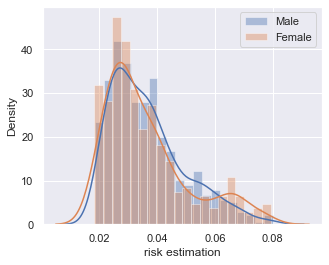

In [70]:
plt.figure(figsize=(5, 4))
sns.distplot(risks_test['th_beta'][A_tt==0], hist=True, kde=True, bins=20, label='Male')
sns.distplot(risks_test['th_beta'][A_tt==1], hist=True, kde=True, bins=20, label='Female')
plt.xlabel('risk estimation')
plt.legend()
plt.show()

# Models

In [5]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [6]:
#Obtain the X, Y and risk
X_train_models = datasets_norm_train['gender'].toarray()
X_test_models = datasets_norm_test['gender'].toarray()

In [527]:
parameters = {'LR__C':[0.01, 0.1, 1], 'LR__fit_intercept':[True, False], 'LR__solver': ['liblinear','lbfgs'], 'LR__class_weight': [None,'balanced'], 'LR__max_iter' : [100000]}
lr = LogisticRegression(random_state=0)
fit_lr = op.get_grid(X_train_models, y_t, parameters, lr, 'LR', scoring=['f1'], refit='f1')


In [479]:
parameters = {'RF__class_weight': ['balanced'],'RF__n_estimators':[10, 50, 100], 'RF__criterion': ['gini', 'entropy'], 'RF__max_depth': [None, 5, 10, 15]}
rf = RandomForestClassifier(random_state=0)

fit_rf = op.get_grid(X_train_models, y_t, parameters, rf, 'RF', scoring=['f1'], refit='f1')


In [480]:
parameters = {'KNN__weights': ['uniform', 'distance'],'KNN__n_neighbors': [5, 10, 15, 20, 25, 30]}
knn = KNeighborsClassifiparameters = {'SVM__probability':[True],'SVM__kernel':['rbf', 'sigmoid', 'poly'], 'SVM__C': [0.001, 0.01, 1, 10, 100], 'SVM__class_weight': [None,'balanced']}
svm = SVC(random_state=0)
fit_svm = op.get_grid(X_train_models, y_t, parameters, svm, 'SVM', scoring=['f1'], refit='f1')
er()

fit_knn = op.get_grid(X_train_models, y_t, parameters, knn, 'KNN', scoring=['f1'], refit='f1')
        

In [481]:
parameters = {'SVM__probability':[True],'SVM__kernel':['rbf', 'sigmoid', 'poly'], 'SVM__C': [0.001, 0.01, 1, 10, 100], 'SVM__class_weight': [None,'balanced']}
svm = SVC(random_state=0)
fit_svm = op.get_grid(X_train_models, y_t, parameters, svm, 'SVM', scoring=['f1'], refit='f1')


In [551]:
models = {'LR': fit_lr,
          'RF': fit_rf,
          'KNN': fit_knn,
          'SVM': fit_svm}


In [130]:
models_results = pd.DataFrame(columns=['model','performance','eq_opp','eq_odd','dem_p'])

for m in models:
    clf = models[m].best_estimator_[m]
    y_pred = clf.predict(X_test_models)

    perfo = fm.f1score(y_tt, y_pred)
    eq_opp = fm.equal_opp_dif(y_tt, y_pred, A_tt, 0)
    eq_odd = fm.equalized_odd_dif(y_tt, y_pred, A_tt, 0)
    dem_p = fm.demographic_parity_dif(y_pred, A_tt,0)

    new_r = {'model': m,
             'performance': perfo,
             'eq_opp': eq_opp,
             'eq_odd': eq_odd,
             'dem_p': dem_p}

    models_results = models_results.append(new_r, ignore_index=True)

In [59]:
models_results = pd.DataFrame(columns=['model','performance','eq_opp','eq_odd','dem_p'])

for m in models:
    clf = models[m].best_estimator_[m]
    y_pred = clf.predict(X_test_models)

    perfo = fm.f1score(y_tt, y_pred)
    eq_opp = fm.equal_opp_dif(y_tt, y_pred, A_tt, 0)
    eq_odd = fm.equalized_odd_dif(y_tt, y_pred, A_tt, 0)
    dem_p = fm.demographic_parity_dif(y_pred, A_tt,0)

    new_r = {'model': m,
             'performance': perfo,
             'eq_opp': eq_opp,
             'eq_odd': eq_odd,
             'dem_p': dem_p}

    models_results = models_results.append(new_r, ignore_index=True)
models_results

,model,performance,eq_opp,eq_odd,dem_p
0,LR,0.655022,0.062442,0.038415,-0.031577
1,RF,0.614634,-0.069276,0.045101,-0.048921
2,KNN,0.551351,-0.085430,0.050235,-0.041620
3,SVM,0.622010,-0.053743,0.036790,-0.046780


In [161]:
with open('checkpoints/models.pickle', 'wb') as f:
    pickle.dump(models, f, protocol=pickle.HIGHEST_PROTOCOL)

In [58]:
with open('checkpoints/models.pickle', 'rb') as f:
    models = pickle.load(f)

fit_lr = models['LR']
fit_rf = models['RF']
fit_knn = models['KNN']
fit_svm = models['SVM']

# Using Risk for Training/Test, and Mitigation

## Using risky samples for training and test separately

In [71]:
threshold = 0.06#risks_train['total'].mean(where=False==np.isnan(risks_train['total']))+risks_train['total'].std(where=False==np.isnan(risks_train['total']))

X_train_high = X_train_models[risks_train['th_beta']>=threshold]
y_train_high = y_t[risks_train['th_beta']>=threshold]
A_train_high = A_t[risks_train['th_beta']>=threshold]

X_train_low = X_train_models[risks_train['th_beta']<threshold]
y_train_low = y_t[risks_train['th_beta']<threshold]
A_train_low = A_t[risks_train['th_beta']<threshold]

X_test_high = X_test_models[risks_test['th_beta']>=threshold]
y_test_high = y_tt[risks_test['th_beta']>=threshold]
A_test_high = A_tt[risks_test['th_beta']>=threshold]

X_test_low = X_test_models[risks_test['th_beta']<threshold]
y_test_low = y_tt[risks_test['th_beta']<threshold]
A_test_low = A_tt[risks_test['th_beta']<threshold]


In [72]:
models_results_both = pd.DataFrame(columns=['model','scenario','performance','eq_opp','eq_odd','dem_p'])
scenario = ['high','low']

for s in scenario:
    if s == 'high':
        X_test_model = X_test_high
        y_test_model = y_test_high
        A_test_model = A_test_high
    else:
        X_test_model = X_test_low
        y_test_model = y_test_low
        A_test_model = A_test_low
        
    clf =  models['LR'].best_estimator_['LR']
    y_pred = clf.predict(X_test_model)

    perfo = fm.f1score(y_test_model, y_pred)
    eq_opp = fm.equal_opp_dif(y_test_model, y_pred, A_test_model, 0)
    eq_odd = fm.equalized_odd_dif(y_test_model, y_pred, A_test_model, 0)
    dem_p = fm.demographic_parity_dif(y_pred, A_test_model,0)

    new_r = {'model': 'LR',
             'scenario': s,
             'performance': perfo,
             'eq_opp': eq_opp,
             'eq_odd': eq_odd,
             'dem_p': dem_p}

    models_results_both = models_results_both.append(new_r, ignore_index=True)
models_results_both

,model,scenario,performance,eq_opp,eq_odd,dem_p
0,LR,high,0.653061,0.500000,0.250000,0.146424
1,LR,low,0.655556,-0.097403,0.059625,-0.061927


## Mitigation

### Removing risky samples from dataset
So not risky in testing

In [79]:
lr = LogisticRegression(random_state=0)
parameters = {'LR__C':[0.01, 0.1, 1], 'LR__fit_intercept':[True, False], 'LR__solver': ['liblinear','lbfgs'], 'LR__class_weight': [None,'balanced'], 'LR__max_iter' : [100000]}

fit_lr_low = op.get_grid(X_train_low, y_train_low, parameters, lr, 'LR', scoring=['f1'], refit='f1')


In [80]:
fit_lr = models['LR']

In [81]:
models_scenario = {'overall': fit_lr, 'rem_high':fit_lr_low, 'rem_high_test':fit_lr}

models_results_rem = pd.DataFrame(columns=['model','scenario','performance','eq_opp','eq_odd','dem_p'])
scenario = ['overall','rem_high', 'rem_high_test']

for s in scenario:
    if s=='overall':
        X_test_model = X_test_models
        y_test_model = y_tt
        A_test_model = A_tt
    else:
        X_test_model = X_test_low
        y_test_model = y_test_low
        A_test_model = A_test_low
        
        
    clf = models_scenario[s].best_estimator_['LR']
    y_pred = clf.predict(X_test_model)

    perfo = fm.f1score(y_test_model, y_pred)
    eq_opp = fm.equal_opp_dif(y_test_model, y_pred, A_test_model, 0)
    eq_odd = fm.equalized_odd_dif(y_test_model, y_pred, A_test_model, 0)
    dem_p = fm.demographic_parity_dif(y_pred, A_test_model,0)

    new_r = {'model': 'LR',
             'scenario': s,
             'performance': perfo,
             'eq_opp': eq_opp,
             'eq_odd': eq_odd,
             'dem_p': dem_p}

    models_results_rem = models_results_rem.append(new_r, ignore_index=True)
models_results_rem

,model,scenario,performance,eq_opp,eq_odd,dem_p
0,LR,overall,0.655022,0.062442,0.038415,-0.031577
1,LR,rem_high,0.662983,-0.058941,0.040394,-0.058802
2,LR,rem_high_test,0.655556,-0.097403,0.059625,-0.061927


### Implementing post-processing approahces

In [53]:
from fairlearn.postprocessing import ThresholdOptimizer

LR_best = fit_lr.best_estimator_['LR']

postprocess_est_eqODD = ThresholdOptimizer(
    estimator=LR_best,
    constraints="equalized_odds",
    objective = 'balanced_accuracy_score',
    prefit=False,
    flip=True)

postprocess_est_demP = ThresholdOptimizer(
    estimator=LR_best,
    constraints="demographic_parity",
    objective = 'balanced_accuracy_score',
    prefit=False,
    flip=True)

postprocess_est_eqOPP = ThresholdOptimizer(
    estimator=LR_best,
    constraints="true_positive_rate_parity",
    objective = 'balanced_accuracy_score',
    prefit=False,
    flip=True)

In [54]:
postprocess_est_eqODD.fit(X_train_models, y_t, sensitive_features=A_t)
postprocess_est_demP.fit(X_train_models, y_t, sensitive_features=A_t)
postprocess_est_eqOPP.fit(X_train_models, y_t, sensitive_features=A_t)


ThresholdOptimizer(constraints='true_positive_rate_parity',
                   estimator=LogisticRegression(C=1, fit_intercept=False,
                                                max_iter=100000, random_state=0,
                                                solver='liblinear'),
                   flip=True, objective='balanced_accuracy_score')

In [55]:
post_processings = {'dem_p': postprocess_est_demP,
                    'eq_odd': postprocess_est_eqODD,
                    'eq_opp': postprocess_est_eqOPP}

models_results_post = pd.DataFrame(columns=['model','scenario','performance','eq_opp','eq_odd','dem_p'])
scenario = ['dem_p','eq_odd', 'eq_opp']

for s in scenario:
    clf = post_processings[s]
    y_pred = clf.predict(X_test_models, sensitive_features=A_tt, random_state=1)

    perfo = fm.f1score(y_tt, y_pred)
    eq_opp = fm.equal_opp_dif(y_tt, y_pred, A_tt, 0)
    eq_odd = fm.equalized_odd_dif(y_tt, y_pred, A_tt, 0)
    dem_p = fm.demographic_parity_dif(y_pred, A_tt,0)

    new_r = {'model': 'LR',
             'scenario': s,
             'performance': perfo,
             'eq_opp': eq_opp,
             'eq_odd': eq_odd,
             'dem_p': dem_p}

    models_results_post = models_results_post.append(new_r, ignore_index=True)
models_results_post

,model,scenario,performance,eq_opp,eq_odd,dem_p
0,LR,dem_p,0.630252,0.062442,0.035441,-0.011008
1,LR,eq_odd,0.626609,0.008388,0.004632,-0.024936
2,LR,eq_opp,0.652174,0.062442,0.039423,-0.033292


We now apply only to the high risky set

In [82]:
postprocess_est_eqODD.fit(X_train_high, y_train_high, sensitive_features=A_train_high)
postprocess_est_demP.fit(X_train_high, y_train_high, sensitive_features=A_train_high)
postprocess_est_eqOPP.fit(X_train_high, y_train_high, sensitive_features=A_train_high)


ThresholdOptimizer(constraints='true_positive_rate_parity',
                   estimator=LogisticRegression(C=1, fit_intercept=False,
                                                max_iter=100000, random_state=0,
                                                solver='liblinear'),
                   flip=True, objective='balanced_accuracy_score')

In [83]:
post_processings = {'dem_p': postprocess_est_demP,
                    'eq_odd': postprocess_est_eqODD,
                    'eq_opp': postprocess_est_eqOPP}

models_results_post_focus = pd.DataFrame(columns=['model','scenario','performance','eq_opp','eq_odd','dem_p'])
scenario = ['dem_p','eq_odd', 'eq_opp']

for s in scenario:
    clf_post = post_processings[s]
    clf = fit_lr.best_estimator_['LR']
    
    y_pred_post = clf_post.predict(X_test_high, 
                              sensitive_features=A_test_high, 
                              random_state=1)
    y_pred_low = clf.predict(X_test_low)
    y_pred_f = np.concatenate((y_pred_post, y_pred_low))
    
    y_test_f = np.concatenate((y_test_high, y_test_low))
    A_test_f = np.concatenate((A_test_high, A_test_low))
    
    perfo = fm.f1score(y_test_f, y_pred_f)
    eq_opp = fm.equal_opp_dif(y_test_f, y_pred_f, A_test_f, 0)
    eq_odd = fm.equalized_odd_dif(y_test_f, y_pred_f, A_test_f, 0)
    dem_p = fm.demographic_parity_dif(y_pred_f, A_test_f,0)

    new_r = {'model': 'LR',
             'scenario': s,
             'performance': perfo,
             'eq_opp': eq_opp,
             'eq_odd': eq_odd,
             'dem_p': dem_p}

    models_results_post_focus = models_results_post_focus.append(new_r, ignore_index=True)
models_results_post_focus

,model,scenario,performance,eq_opp,eq_odd,dem_p
0,LR,dem_p,0.599078,-0.169307,0.102636,-0.074005
1,LR,eq_odd,0.601852,-0.169307,0.101628,-0.072290
2,LR,eq_opp,0.603774,-0.157813,0.092857,-0.065429


# Profiles

In [73]:
aware_dataset = pd.DataFrame(X_tt, columns=gender_features)
gender_dataset = pd.DataFrame(A_tt, columns=['gender'])
risk_dataset = pd.DataFrame(risks_test['th_beta'], columns=['risk'])
label_dataset = pd.DataFrame(y_tt, columns = ['label'])
bins = pd.DataFrame(np.zeros((y_tt.shape[0])), columns = ['bins'])
profile_dataset = pd.concat([aware_dataset, gender_dataset, risk_dataset, label_dataset, bins], axis=1)
#Scaled and standardize all variables
for i in range(len(profile_dataset.columns)-4):
     profile_dataset.iloc[:,i]=(profile_dataset.iloc[:,i]-profile_dataset.iloc[:,i].mean())/(profile_dataset.iloc[:,i].std())
        
profile_dataset

,Ing_Bruto_Familiar_F,Preferencia_Carrera_F,Colegio_Promedio_PSU,Colegio_Total_Alumnos,Prom_Alumn_Dif,PSU_Matematica_F,PSU_Lenguaje_F,PSU_Ranking_F,Prom_1er_Sem,Primer_Semestre_MEM,...,UD_Reprobadas_Primer_Semestre,Posterga_Primer_Semestre_Final,Posterga_Segundo_Semestre_F,CausalSem-11,CausalSem-12,public_school,gender,risk,label,bins
0,1.381584,0.808659,0.742338,-0.117495,0.023443,0.865324,0.154470,-0.167073,0.191963,-0.013831,...,-0.648177,-0.0925,-0.187423,-0.135495,-0.316797,-0.550075,0,0.038734,0,0.0
1,0.865656,-0.668833,1.185503,-0.522578,-0.152699,0.743775,0.543374,-1.402031,-1.464029,-0.227238,...,0.727784,-0.0925,-0.187423,-0.135495,3.153240,-0.550075,0,0.061932,0,0.0
2,-0.682127,-0.668833,-2.194397,-0.573213,1.958691,-0.816102,0.429944,1.671641,-0.560761,-0.760757,...,0.383794,-0.0925,-0.187423,-0.135495,3.153240,1.816003,1,0.066928,0,0.0
3,-0.940090,-0.668833,-2.869555,-0.598531,-0.375830,-1.970817,-2.016914,1.671641,-5.227647,-3.428348,...,4.167686,-0.0925,-0.187423,7.372517,3.153240,1.816003,0,0.054199,0,0.0
4,-0.682127,0.808659,-2.106409,-0.573213,1.194739,-1.140233,-0.072391,1.671641,-0.861850,0.199576,...,1.415764,-0.0925,-0.187423,-0.135495,-0.316797,-0.550075,1,0.027343,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,-0.424163,0.808659,0.426463,-0.615409,-0.602998,0.399386,-0.526113,0.807171,-0.861850,-0.485170,...,1.071774,-0.0925,-0.187423,-0.135495,-0.316797,-0.550075,0,0.038374,0,0.0
938,0.865656,3.763643,-0.369239,0.025972,0.582713,0.480419,-0.137209,-0.029856,-0.560761,-0.120535,...,-0.648177,-0.0925,-0.187423,-0.135495,-0.316797,-0.550075,0,0.036143,0,0.0
939,1.381584,0.808659,0.905409,-0.168130,0.814493,1.351519,0.835053,-0.578726,0.191963,0.199576,...,0.039804,-0.0925,-0.187423,-0.135495,-0.316797,-0.550075,0,0.029957,0,0.0
940,0.865656,0.808659,0.639393,-0.438186,-1.605071,0.379128,-1.401149,-0.537561,-0.259671,0.519687,...,0.383794,-0.0925,-0.187423,-0.135495,-0.316797,-0.550075,1,0.029177,1,0.0


In [74]:
translated_col = np.array(['family_income', 'application_pref', 'SAT_ave', 'n_students_hs', 
                  'GPA_hs_diff', 'SAT_math', 'SAT_verbal', 'SAT_rank', 'GPA_1sem', 
                  'GPA_1sem_MAT', 'GPA_1sem_ECO', 'GPA_1sem_BUS', 'teacher_rate_1sem', 
                  'GPA_2_sem', 'GPA_2sem_MAT', 'GPA_2sem_ECO', 'GPA_2sem_BUS', 'GPA_2sem_other', 
                  'failed_credits_2sem', 'teacher_rate_2sem', 'type_HS ', 'type_admission', 
                  'region_residence', 'EDT_participation', 'EDV_participation', 'PAA_participation_1sem', 
                  'PAA_participation_2sem', 'failed_credits_1sem', 'postpone_1sem', 'postpone_2sem', 
                  'aw_1sem', 'aw_2sem', 'public_school', 'gender', 'risk', 'label', 'bins'])
profile_dataset.columns = translated_col       

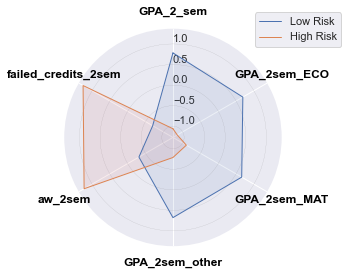

In [75]:
#Plot
numbers_features = 6
features = translated_col
bins =5
priv = 0
sens_attr = 'gender'
ascending = True

profile_dataset_result, ds_radarchart_result, categories = ut.plotProfiles(profile_dataset=profile_dataset, 
                                                 numbers_features=numbers_features, 
                                                 features=features, 
                                                 bins=5, 
                                                 priv=priv, 
                                                 sens_attr=sens_attr, 
                                                 ascending=ascending)